## Artificial Anime Character Design: An Application of Generative Adversarial Networks (GANs)
Implementations of DCGAN, LSGAN, and StyleGAN on dataset of anime character faces.

Generative Adversarial Networks (GANs) are
novel deep-learning architectures that excel in
creating artificial images. GANs have been successfully applied to many types of images, most
notably human faces, but each category comes
with unique challenges. We focus on using GAN
to generate artificial anime character faces. We
implement three variations of GAN - DCGAN,
LSGAN, and StyleGAN, and trained on a data
set of 20,000 images. 

### Setting Up

Connect to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Decompress and extract dataset

In [0]:
DATASET_PATH = '/content/drive/My Drive/Anime Dataset/anime_dataset.7z' # Please replace with path to your 7z file
ESCAPED_PATH = DATASET_PATH.replace(" ", "\\ ") 

In [0]:
!7z x {ESCAPED_PATH} # Here we decompress / extract the dataset

Set up TensorBoard

In [0]:
%load_ext tensorboard

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
ROOT_LOG_DIR = "/content/drive/My Drive/CIS 519 Project"
TENSORBOARD_DIR = "logs" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, TENSORBOARD_DIR))

Set up GPU

In [0]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Deep Convolutional GAN (DCGAN)
Implementation based on paper by Radford et al., 2015

Our dataset consists of 21551 unlabeled anime faces obtained from Kaggle (Rakshit, 2019). This is a cleaner
version of a dataset originally on Github (Chao, 2019)
where the images are fetched from Getchu.com and then
cropped using the anime face detection algorithm (Nagadomi, 2011). Here we transform and load the dataset using Pytorch’s ImageFolder and DataLoader classes. 

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision import transforms, utils

# Function to load data
def load_data(data_folder, input_size, batch_size, shuffle):
    # Transform properties
    input_transforms = transforms.Compose([
            transforms.Pad(34, fill=(255, 255, 255)),
            transforms.CenterCrop((64,64)),
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

    # Create dataset using ImageFolder and Dataloader
    dataset = datasets.ImageFolder(root=data_folder, transform=input_transforms)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

    return dataloader 

# Create dataloader
data_folder = '/content/anime_dataset'
dataloader = load_data(data_folder, 64, 64, True)

torch.Size([64, 3, 64, 64])


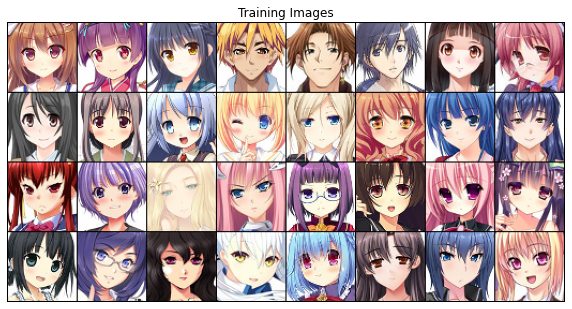

In [0]:
# Plot some images
import matplotlib.pyplot as plt
import numpy as np
images, labels = next(iter(dataloader))
print(images.shape)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(images.to(device)[:32], padding=1, normalize=True).cpu(),(1,2,0)))
plt.show()

Define some parameters



In [0]:
# Size of z latent vector
nz = 100
# Size of feature maps in generator
nfg = 64
# Size of feature maps in discriminator
nfd = 64

Create a normally distributed vector $z$ with $\mu = 0$, $\sigma = 1$ (i.e the np.random.normal default). The vector should have size [batch size, feature length, 1, 1]. Here feature length describes the length of your vector $z$.


In [0]:
import numpy as np
def z_vector(batch_size=64, feature_length=100):
    # Adapted from recitation
    z = np.random.normal(0, 1, (batch_size, feature_length))
    z = z.reshape((batch_size, feature_length, 1, 1))
    z = torch.tensor(z).float().to(device)
    
    return z

# Test z shape
z = z_vector().to(device)
z.shape

torch.Size([64, 100, 1, 1])

Create the generator network. Use [ConvTranspose2d](https://pytorch.org/docs/stable/nn.html) to upsample the noise vector $z$ to a size of your choosing (512 is what we used). Deconvolve it until the number of channels is 3 (so it's RGB), and the output size is (64,64).  In other words, the output of the generator should be [batch size,3,64,64]. Use ReLU and batch norm after every deconvolution and use a sigmoid layer at the end to create your final output.

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

# Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input z vector
            nn.ConvTranspose2d(nz, nfg*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nfg*8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Output size: (nfg*8) * 4^2
            nn.ConvTranspose2d(nfg*8, nfg*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg*4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Output size: (nfg*4) * 8^2
            nn.ConvTranspose2d(nfg*4, nfg*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg*2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Output size: (nfg*2) * 16^2
            nn.ConvTranspose2d(nfg*2, nfg, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Output size: (nfg) * 32^2
            nn.ConvTranspose2d(nfg, 3, 4, 2, 1, bias=False),
            # nn.Sigmoid()
            nn.Tanh()
            # Final output size: 3 * 64 * 64
        )
        self._initialize_weights()

    # Custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)
                
    def forward(self, input):
        return self.main(input)

Create the discriminator network. This should feel very similar to creating a CNN to classify whether an example is in the distribution or not in the distribution.

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input 3 * 64 * 64 (from generator)
            nn.Conv2d(3, nfd, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Output size: (nfd) * 32^2
            nn.Conv2d(nfd, nfd*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Output size: (nfd*2) * 16^2
            nn.Conv2d(nfd*2, nfd*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Output size: (nfd*4) * 8^2
            nn.Conv2d(nfd*4, nfd*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.ReLU(True),
            # Ouput size: (nfd*8) * 4^2
            nn.Conv2d(nfd*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Ouput size: (nfd*8) * 4^2

        )
        self._initialize_weights()

    # Custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        return self.main(input)
        # output = self.main(input)
        # return output.view(-1,1)

Code the loss function for the generator, it should be as follows:

$$ L_G = -\frac{1}{n}\sum_{i=1}^{n}\lg D(G(z))$$

An alternate form for convenince is:
$$ L_G = \frac{1}{n}\sum_{i=1}^{n}L_{CE}(D(G(z)), 1)$$

Where $L_{CE}$ is the cross entropy loss function and n is the batch size.



In [0]:
def generator_loss(d, fake, criterion, label):
    # Forward pass fake (G(z)) through D and calculate generator loss
    output = d(fake).view(-1)
    loss = criterion(output, label)

    return loss

Code the loss function for the discriminator, it should be as follows:

$$ L_D = \frac{1}{2n}\sum_{i=1}^{n}L_{CE}(D(X_i), 1) + L_{CE}(D(G(z)), 0)$$

Where $L_{CE}$ is the cross entropy loss function and n is the batch size. Be sure to not normalize by $n$ twice (if we feed in two vectors into BCELoss, they normalize it by the size of the vector for us).

**Important:** Remember to **detach** generator when calculating this loss.

In [0]:
def discriminator_loss(criterion, d, real_img, fake, real_label, fake_label):
    # Forward pass real images through D and calculate real loss
    real_output = d(real_img).view(-1)
    real_loss = criterion(real_output, real_label)
    # Classify all fake (G(z)) with D and calculate fake loss
    fake_output = d(fake.detach()).view(-1)
    fake_loss = criterion(fake_output, fake_label)
    
    # LD = (LR + LF)/2
    return (real_loss + fake_loss)/2, real_loss, fake_loss

Create two optimizers, one for Discriminator network and one for generator network. 

In [0]:
# Create generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Setup Adam optimizers for both G and D
optimizerG = optim.Adam(netG.parameters(), lr=0.0005, betas=(0.5, 0.999), weight_decay=1e-4)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-4)

# Initialize loss function                         
criterion = nn.BCELoss().to(device)

Put all of these parts together to create a GAN. The training loop should look as follows:

**Training Loop:**

1.   Create vector $z$
2.   Zero out the gradient for $G$
3.   Generate fake image, and calculate $L_G$
4.   Backpropagate $L_G$ and have optimizer take a step
5.   Zero out the gradient for $D$
6.   Calculate $L_D$
7.   Backpropagate $L_D$ and step optimizer.

**Hints for training:**

1.   Make sure to use tensorboard to keep track of the discriminator AND generator losses throughout. Note that if discriminator loss goes to 0, this represents a failure mode of training (look at how the generator loss function is calculated and realize that G's gradients vanish).
2.   Keep vigilant for mode collapse. Display image after every delta number of iterations to see that not only is the image getting better, but also not getting the same image each time. If so, then the network is suffering from mode collapse.
3.   Analyze generator loss and make sure that it's roughly oscillating around a certain loss. Unlike most other tasks, generator and discriminator loss are NOT intended to monotonically decrease. Instead they should bounce around a certain loss (see image below for example). The graph doesn't have to look exactly like this but this is meant to illustrate how the loss should roughly bounce around a certain loss.
![Discriminator Loss](https://i.imgur.com/07JYtA1.png)
![Generator Loss Graph](https://i.imgur.com/NoMFLNg.png)

On the left is the discriminator loss graph, and as we can see, the discriminator loss as a whole goes down but not monotonically. It bounces around signifcantly at each iteration. On the right is the generator graph, whose loss actually increases. Like the discriminator loss graph, we can see that the loss varies significantly from iteration to iteration.


**Hyperparameter Tuning:**

What makes GAN's difficult to train is that they are extremely sensitive to hyperparameters. Some hyperparameters to think about when tuning GANs:


1.   The number of times to run discriminator vs. generator (generally run discriminator more times than generator because the discriminator is what gives generator feedback).
2.   The learning rate for discriminator / generator
3.   Image output size
4.   Feature vector size (i.e. the length of z)
5.   Standard neural network hyperparameters (i.e. number of layers, width of layers, batch size, etc.)



In [0]:
# Generate images to keep track of progress of G in training
def generate_trn_images(g, z, show=True):
    import matplotlib.pyplot as plt
    import numpy as np
    imgs = g(z).detach()
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(utils.make_grid(imgs.to(device)[:32], padding=1, normalize=True).cpu(),(1,2,0)))
    plt.show()

In [0]:
# GAN training function
def trainGAN(dataloader, netG, netD, optimizerG, optimizerD, criterion, epochs):
    step = 0
    img_list = []
    latent_vec = z_vector(batch_size=64, feature_length=100).to(device)
    
    for epoch in range(epochs):
        for idx, (real_img, label) in enumerate(dataloader):
            batch_size = real_img.size(0)
            real_img = real_img.to(device)

            # Create real/fake labels for D
            real_label = torch.from_numpy(np.full(batch_size, 0.9, np.float32)).to(device)
            fake_label = torch.from_numpy(np.full(batch_size, 0.1, np.float32)).to(device)
            # Create label for G
            label = torch.full((batch_size,), 1, device=device)

            # 1. Create z vector
            z = z_vector(batch_size=batch_size, feature_length=100).to(device)
            # 2. Zero out gradient for G
            netG.zero_grad()
            # 3. Generate fake image and calculate LG
            fake = netG(z)
            LG = generator_loss(netD, fake, criterion, label)
            # 4. Backpropagate LG and step optimizer
            LG.backward()
            optimizerG.step()
            # 5. Zero out gradient for D
            netD.zero_grad()
            # 6. Calculate LD
            LD, LR, LF = discriminator_loss(criterion, netD, real_img, fake, real_label, fake_label)
            # 7. Backpropogate LD and step optimizer
            LR.backward()
            LF.backward()
            optimizerD.step()

            # Output training stats
            if idx % 100 == 0:
                print('[%3d/%3d][%3d/%3d]\tLoss_D: %.4f\tLoss_G: %.4f'
                      % (epoch, epochs, idx, len(dataloader), LD.item(), LG.item()))
                
            # Plot loss on Tensorboard
            if step % 50 == 0:
              logger.add_scalar('Loss G', LG, step)
              logger.add_scalar('Loss D', LD, step) 

            # Save G's output in list
            if (step % 500 == 0) or ((epoch == epochs-1) and (idx == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(latent_vec).detach().cpu()
                img_list.append(utils.make_grid(fake, padding=1, normalize=True))

            step += 1

        # Generate images to keep track of progress of G
        generate_trn_images(netG, latent_vec, True)

        # Save model
        torch.save(netG.state_dict(),'/content/drive/My Drive/CIS 519 Project/Generator.pt')       

    # return img_list
    return netG, img_list

In [0]:
# Display TensorBoard
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

In [0]:
# Train GAN
generator, fake_imgs = trainGAN(dataloader=dataloader, netG=netG, netD=netD, 
                       optimizerG=optimizerG, optimizerD=optimizerD, 
                       criterion=criterion, epochs=150)

Animation to show progress of generator

In [0]:
import matplotlib.animation as animation
from IPython.display import HTML

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fake_imgs]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Compare real vs fake images

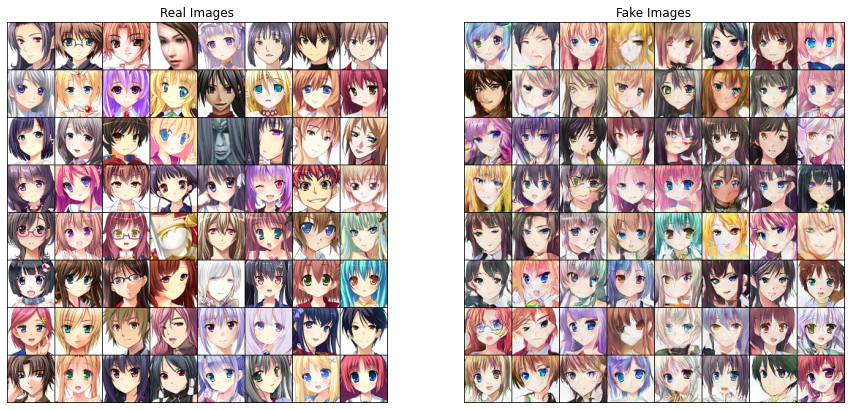

In [0]:
import matplotlib.pyplot as plt

# Plot real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))

# Plot fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_imgs[-1],(1,2,0)))
plt.show()

General sample images

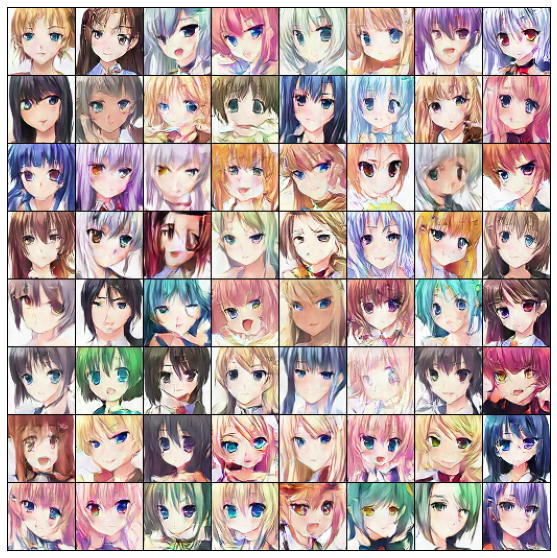

In [0]:
# Generate sample fake images and save to drive
from torchvision.utils import save_image
def generate_final_images(g, z, show=True):
    import matplotlib.pyplot as plt
    import numpy as np
    imgs = g(z).detach()
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(utils.make_grid(imgs.to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
    plt.show()
    for i in range(1024):
      save_image(imgs[i],"/content/drive/My Drive/CIS 519 Project/sample_images/sample{}.png".format(i),normalize=True)

z = z_vector(batch_size=1024, feature_length=100).to(device)
generate_final_images(netG, z, True)

## Least Square GAN (LSGAN)
The main idea of LSGAN is to use loss function that provides smooth and non-saturating gradient in discriminator 
D


Implement the above GAN model with the follwing objective:
$$\begin{aligned}
&\min _{D} V_{\mathrm{LSGAN}}(D)=\frac{1}{2} \mathbb{E}_{\boldsymbol{x} \sim p_{\mathrm{dnta}}(\boldsymbol{x})}\left[(D(\boldsymbol{x})-1)^{2}\right]+\frac{1}{2} \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}\left[(D(G(\boldsymbol{z})))^{2}\right]\\
&\min _{G} V_{\mathrm{LSGAN}}(G)=\frac{1}{2} \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}\left[(D(G(\boldsymbol{z}))-1)^{2}\right]
\end{aligned}$$
The model architecture we used for LSGAN is exactly the
same as that of DCGAN, with a few minor changes. First,
we removed the sigmoid activation function at the end of
D. Moreover, we adjusted the LG and LD functions to
follow the objective functions described above. We also
use the same hyperparameters as we did for DCGAN.




Create generator network

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

# Generator class from before
class GeneratorLS(nn.Module):
    def __init__(self):
        super(GeneratorLS, self).__init__()
        self.main = nn.Sequential(
            # Input z vector
            nn.ConvTranspose2d(nz, nfg*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nfg*8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (nfg*8) * 4^2
            nn.ConvTranspose2d(nfg*8, nfg*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg*4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (nfg*4) * 8^2
            nn.ConvTranspose2d(nfg*4, nfg*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg*2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (nfg*2) * 16^2
            nn.ConvTranspose2d(nfg*2, nfg, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (nfg) * 32^2
            nn.ConvTranspose2d(nfg, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Final output size: 3 * 64 * 64
        )
        self._initialize_weights()

    # Custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)
                
    def forward(self, input):
        return self.main(input)

Create discriminator network

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

# Discriminator class from before (without sigmoid)
class DiscriminatorLS(nn.Module):
    def __init__(self):
        super(DiscriminatorLS, self).__init__()
        self.main = nn.Sequential(
            # Input 3 * 64 * 64 (from generator)
            nn.Conv2d(3, nfd, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (nfd) * 32^2
            nn.Conv2d(nfd, nfd*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (nfd*2) * 16^2
            nn.Conv2d(nfd*2, nfd*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output size: (nfd*4) * 8^2
            nn.Conv2d(nfd*4, nfd*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*8),
            nn.LeakyReLU(0.2, inplace=True),
            # Ouput size: (nfd*8) * 4^2
            nn.Conv2d(nfd*8, 1, 4, 1, 0, bias=False),
            # Remove nn.Sigmoid()
        )
        self._initialize_weights()

    # Custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        return self.main(input)

Code loss functions

In [0]:
# LSGAN generator loss
def LS_generator_loss(d, fake, label):
    # Forward pass fake (G(z)) through D and calculate generator loss
    output = d(fake).view(-1)
    loss = 0.5 * torch.mean((output-label)**2)

    return loss

# LSGAN discriminator loss
def LS_discriminator_loss(d, real_img, fake, real_label, fake_label):
    # Forward pass real images through D and calculate real loss
    real_output = d(real_img).view(-1)
    real_loss = 0.5 * torch.mean((real_output-real_label)**2)
    # Classify all fake (G(z)) with D and calculate fake loss
    fake_output = d(fake.detach()).view(-1)
    fake_loss = 0.5 * torch.mean((fake_output-fake_label)**2)
    
    # LD = LR + LF
    return real_loss + fake_loss, real_loss, fake_loss

Create optimizers

In [0]:
# Create generator and discriminator
netLSG = GeneratorLS().to(device)
netLSD = DiscriminatorLS().to(device)

# Setup Adam optimizers for both G and D
optimizerLSG = optim.Adam(netLSG.parameters(), lr=0.0005, betas=(0.5, 0.999), weight_decay=1e-4)
optimizerLSD = optim.Adam(netLSD.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-4)

Put all of these parts together to create a GAN.

In [0]:
# GAN training function
def trainLSGAN(dataloader, netG, netD, optimizerG, optimizerD, epochs):
    step = 0
    img_list = []
    latent_vec = z_vector(batch_size=64, feature_length=100).to(device)
    
    for epoch in range(epochs):
        for idx, (real_img, label) in enumerate(dataloader):
            batch_size = real_img.size(0)
            real_img = real_img.to(device)

            # Create real/fake labels for D
            real_label = torch.from_numpy(np.full(batch_size, 0.9, np.float32)).to(device)
            fake_label = torch.from_numpy(np.full(batch_size, 0.1, np.float32)).to(device)
            # Create label for G
            label = torch.full((batch_size,), 1, device=device)

            # 1. Create z vector
            z = z_vector(batch_size=batch_size, feature_length=100).to(device)
            # 2. Zero out gradient for G
            netG.zero_grad()
            # 3. Generate fake image and calculate LG
            fake = netG(z)
            LG = LS_generator_loss(netD, fake, label)
            # 4. Backpropagate LG and step optimizer
            LG.backward()
            optimizerG.step()
            # 5. Zero out gradient for D
            netD.zero_grad()
            # 6. Calculate LD
            LD, LR, LF = LS_discriminator_loss(netD, real_img, fake, real_label, fake_label)
            # 7. Backpropogate LD and step optimizer
            LR.backward()
            LF.backward()
            optimizerD.step()

            # Output training stats
            if idx % 100 == 0:
                print('[%3d/%3d][%3d/%3d]\tLoss_D: %.4f\tLoss_G: %.4f'
                      % (epoch, epochs, idx, len(dataloader), LD.item(), LG.item()))
                
            # Plot loss on TensorBoard
            if step % 50 == 0:
              logger.add_scalar('LSGAN Loss G', LG, step)
              logger.add_scalar('LSGAN Loss D', LD, step) 

            # Save G's output in list
            if (step % 500 == 0) or ((epoch == epochs-1) and (idx == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(latent_vec).detach().cpu()
                img_list.append(utils.make_grid(fake, padding=1, normalize=True))

            step += 1

        # Generate images to keep track of progress of G
        generate_trn_images(netG, latent_vec, True)

        # Save model
        torch.save(netG.state_dict(),'/content/drive/My Drive/CIS 519 Project/LS_Generator.pt')       

    # return img_list
    return netG, img_list

In [0]:
# Train GAN
LSG_generator, LSG_fake_imgs = trainLSGAN(dataloader=dataloader, netG=netLSG, netD=netLSD, 
                       optimizerG=optimizerLSG, optimizerD=optimizerLSD, epochs=150)

Animation to show progress of generator

In [0]:
import matplotlib.animation as animation
from IPython.display import HTML

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in LSG_fake_imgs]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Compare real vs fake images

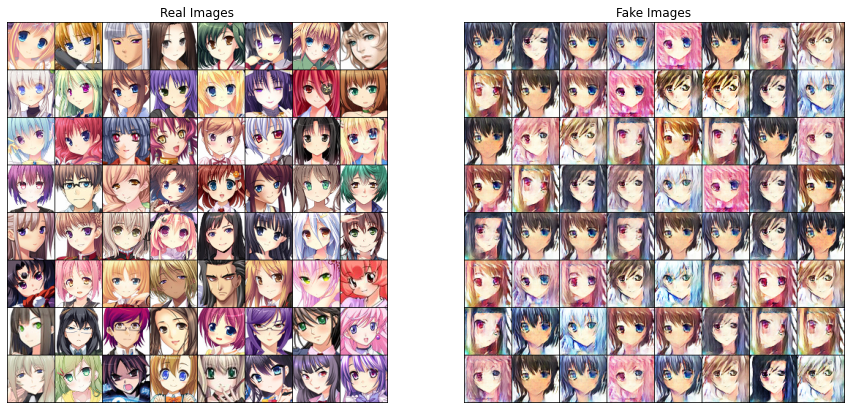

In [0]:
import matplotlib.pyplot as plt

# Plot real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))

# Plot fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(LSG_fake_imgs[-1],(1,2,0)))
plt.show()

Generate sample fake images

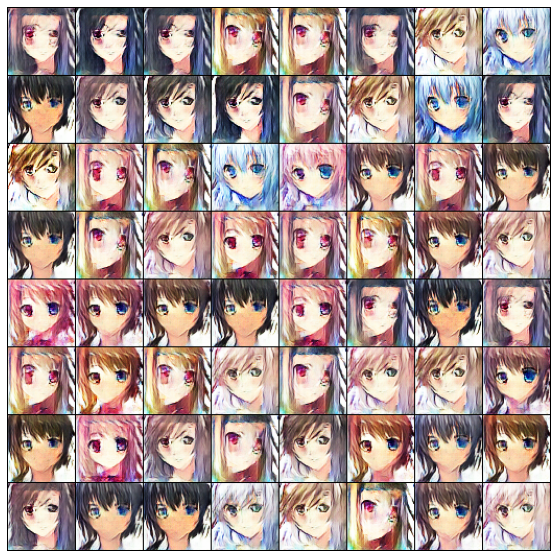

In [0]:
# Generate sample fake images and save to drive
from torchvision.utils import save_image
def LSG_generate_final_images(g, z, show=True):
    import matplotlib.pyplot as plt
    import numpy as np
    imgs = g(z).detach()
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(utils.make_grid(imgs.to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
    plt.show()
    for i in range(1024):
      save_image(imgs[i],"/content/drive/My Drive/CIS 519 Project/LSG_sample_images/sample{}.png".format(i),normalize=True)

z = z_vector(batch_size=1024, feature_length=100).to(device)
LSG_generate_final_images(netLSG, z, True)

## StyleGAN
Implementation of NVIDIA's open-source code (Karras et al., 2019)

StyleGAN and StyleGAN2 are new state-of-the-art GAN
architectures developed by a team from NVIDIA (Karras
et al., 2018; 2019). These architectures address many of
the shortcomings of previous GAN implementations and
dramatically increase image quality.

https://github.com/lucidrains/stylegan2-pytorch

In [0]:
!pip install stylegan2_pytorch

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 163kB 18.1MB/s 
  Created wheel for stylegan2-pytorch: filename=stylegan2_pytorch-0.6.7-cp36-none-any.whl size=9577 sha256=efd3bdb1e80c764e791f6a62750ea873af0af8d87e536f0bf3094faf7e71c953
  Stored in directory: /root/.cache/pip/wheels/49/52/c5/058231cff44454de53554646c83905fbb3cc5df840a325377e
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=d4c20c3485c01751fa1f9c14ce415d1434f0b47dd1b045ddca4b80993030a8a0
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
  Created wheel for contrastive-learner: filename=contrastive_learner-0.0.8-cp36-none-any.whl size=3914 sha256=493af82521095046a56f2be7718d61d5d45fb3019b128b74fa44ee483aec4edc
  Stored in directory: /root/.cache/pip/wheels/42/ad/c8/8f49beb4000b3d140a47e7cc48971e3d5640f71a5546f1e776
Successfully built stylegan2-pytorch fire contrastive-learner


In [0]:
!unzip -q "drive/My Drive/Colab Notebooks/anime-faces.zip"

In [0]:
!stylegan2_pytorch --data ./data --name anime-GAN --results_dir "./drive/My Drive/Colab Notebooks/results" --models_dir "./drive/My Drive/Colab Notebooks/models"

continuing from previous epoch - 108
anime-GAN<./data>:   0% 0/42000 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
G: 0.83 | D: 0.34 | GP: 0.04 | PL: 0.01 | CR: 0.00
anime-GAN<./data>:   0% 41/42000 [00:31<10:26:04,  1.12it/s]G: 1.17 | D: 0.46 | GP: 0.23 | PL: 0.01 | CR: 0.00
anime-GAN<./data>:   0% 92/42000 [01:02<8:16:08,  1.41it/s]G: 1.18 | D: 0.45 | GP: 0.09 | PL: 0.01 | CR: 0.00
anime-GAN<./data>:   0% 143/42000 [01:34<7:35:08,  1.53it/s]G: 1.17 | D: 0.49 | GP: 0.18 | PL: 0.02 | CR: 0.00
anime-GAN<./data>:   0% 193/42000 [02:05<7:23:04,  1.57it/s]G: 1.04 | D: 0.49 | GP: 0.06 | PL: 0.02 | CR: 0.00
anime-GAN<./data>:   1% 244/42000 [02:36<7:12:27,  1.61it/s]G: 1.16 | D: 0.58 | GP: 0.04 | PL: 0.02 | CR: 0.00
anime-GAN<./data>:   1% 295/42000 [03:08<7:12:54,  1.61it/s]G: 0.89 | D: 0.50 | 

In [0]:
!stylegan2_pytorch --name anime-GAN --results_dir "./drive/My Drive/Colab Notebooks/results" --models_dir "./drive/My Drive/Colab Notebooks/models" --generate --num_image_tiles 2

In [0]:
from stylegan2_pytorch import Trainer, NanException

In [0]:
from datetime import datetime

In [0]:
name = 'anime-GAN'
#results_dir = './drive/My Drive/Colab Notebooks/results'
results_dir = './drive/My Drive/Colab Notebooks/generated'
models_dir = './drive/My Drive/Colab Notebooks/models'
batch_size = 3
gradient_accumulate_every = 5
image_size = 128
network_capacity = 16
transparent = False
learning_rate = 2e-4
num_workers =  None
save_every = 1000
trunc_psi = 0.75
fp16 = False
cl_reg = False

load_from = -1

model = Trainer(
        name,        
        results_dir,
        models_dir,
        batch_size = batch_size,
        gradient_accumulate_every = gradient_accumulate_every,
        image_size = image_size,
        network_capacity = network_capacity,
        transparent = transparent,
        lr = learning_rate,
        num_workers = num_workers,
        save_every = save_every,
        trunc_psi = trunc_psi,
        fp16 = fp16,
        cl_reg = cl_reg
    )

model.load(load_from)

In [0]:
num_image_tiles = 16

def generate():
    now = datetime.now()
    timestamp = now.strftime("%m-%d-%Y_%H-%M-%S")
    samples_name = f'generated-{timestamp}'
    model.evaluate(samples_name, num_image_tiles)
    print(f'sample images generated at {results_dir}/{name}/{samples_name}')

generate()

We acknowledge NVIDIA for their open-source StyleGAN
implementation (Karras et al., 2019), Google for supplying
the Inception V3 model (Google, 2015)